NAME: A-n32-k5
- 文件名含义：A 表示数据集分类，n32 表示包含仓库在内共有 32个节点，k5 表示需要使用 5辆车 完成配送。

COMMENT: (Augerat et al, No of trucks: 5, Optimal value: 784)
- 数据来源：由 Augerat 等研究者提出。
- 已知最优解：使用 5 辆车时，总行驶距离为 784（验证算法效果的基准值）。

TYPE: CVRP
- 问题类型是标准的带容量约束的车辆路径问题。
- DIMENSION: 32

节点总数（包括仓库）。
- EDGE_WEIGHT_TYPE: EUC_2D
- 节点间距离基于 二维欧几里得距离 计算，需四舍五入为整数。

CAPACITY: 100
- 每辆车的最大载重量（容量约束）。

## 步骤1：解析数据文件
读取节点坐标、需求和车辆参数，处理成适当的数据结构。

In [6]:
import re


k = re.search(r'k(\d+)', '12323k11').group(1)
k

'11'

In [ ]:
import os
import vrplib


def read_all_instances(root_folder, ending = '.vrp'):
    instances = []

    for file_name in os.listdir(root_folder):
        if file_name.endswith(ending):
            instance = vrplib.read_instance(str(os.path.join(root_folder, file_name)))

            if instance:
                instances.append(instance)
                print(f'Successfully read {file_name}')
            else:
                print(f'Failed to read {file_name}')
    return instances

In [30]:
instances = read_all_instances('./cvrp','.vrp')
def create_data_model(instance):
    data = {}
    # 基础参数设置
    data["vehicle_capacity"] = instance['capacity']
    data["num_vehicles"] = int(re.search(r'k(\d+)', instance['name']).group(1))
    data["depot"] = instance['depot']
    data['locations'] = [tuple(row) for row in instance['node_coord'].tolist()]
    data["num_locations"] = len(data["locations"])
    data['demands'] = instance['demand']
    data['distance_matrix']= instance['edge_weight']
    
    return data
    

Successfully read A-n32-k5.vrp


In [31]:
def add_capacity_constraints(routing, manager, data, demand_eval_idx):
    """添加容量约束"""
    capacity = data["vehicle_capacity"]
    routing.AddDimension(
        demand_eval_idx,
        capacity,  # 车辆最大容量
        capacity,  # 车辆初始容量
        True,  # 强制初始容量为0
        "Capacity"
    )
    
# 初始化模型
data = create_data_model(instances[0])
node_coords = [(0, 0)] * len(data['distance_matrix'])

# # 创建路由管理器
# manager = pywrapcp.RoutingIndexManager(
#     data["num_locations"],
#     data["num_vehicles"],
#     data["depot"]
# )
data

{'vehicle_capacity': 100,
 'num_vehicles': 5,
 'depot': array([0]),
 'locations': [(82, 76),
  (96, 44),
  (50, 5),
  (49, 8),
  (13, 7),
  (29, 89),
  (58, 30),
  (84, 39),
  (14, 24),
  (2, 39),
  (3, 82),
  (5, 10),
  (98, 52),
  (84, 25),
  (61, 59),
  (1, 65),
  (88, 51),
  (91, 2),
  (19, 32),
  (93, 3),
  (50, 93),
  (98, 14),
  (5, 42),
  (42, 9),
  (61, 62),
  (9, 97),
  (80, 55),
  (57, 69),
  (23, 15),
  (20, 70),
  (85, 60),
  (98, 5)],
 'num_locations': 32,
 'demands': array([ 0, 19, 21,  6, 19,  7, 12, 16,  6, 16,  8, 14, 21, 16,  3, 22, 18,
        19,  1, 24,  8, 12,  4,  8, 24, 24,  2, 20, 15,  2, 14,  9]),
 'distance_matrix': array([[  0.        ,  34.92849839,  77.87810989, ...,  62.28964601,
          16.2788206 ,  72.78049189],
        [ 34.92849839,   0.        ,  60.30754513, ...,  80.32434251,
          19.41648784,  39.05124838],
        [ 77.87810989,  60.30754513,   0.        , ...,  71.58910532,
          65.19202405,  48.        ],
        ...,
        [ 62

In [ ]:
def create_distance_evaluator(data):
    def distance_evaluator(manager, from_idx, to_idx):
        """返回节点间的距离"""
        from_node = manager.IndexToNode(from_idx)
        to_node = manager.IndexToNode(to_idx)
        return data['distance_matrix'][from_node][to_node]
        
    return distance_evaluator

def create_demand_evaluator(data):
    """创建需求评估函数"""
    _demands = data["demands"]
    
    def demand_evaluator(manager, node_idx):
        return _demands[manager.IndexToNode(node_idx)]
    
    return demand_evaluator


In [1]:
from functools import partial
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
# 初始化模型
data = create_data_model(instances[0])

# 创建路由管理器
manager = pywrapcp.RoutingIndexManager(
    data["num_locations"],
    data["num_vehicles"],
    0
)

# 创建路由模型
routing = pywrapcp.RoutingModel(manager)

# 注册距离评估函数
distance_eval_idx = routing.RegisterTransitCallback(
    partial(create_distance_evaluator(data), manager)
)
routing.SetArcCostEvaluatorOfAllVehicles(distance_eval_idx)
# 添加容量约束
demand_eval_idx = routing.RegisterUnaryTransitCallback(
    partial(create_demand_evaluator(data), manager)
)
add_capacity_constraints(routing, manager, data, demand_eval_idx)


# 配置求解参数
search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_params.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_params.time_limit.FromSeconds(5)

# 执行求解
solution = routing.SolveWithParameters(search_params)



NameError: name 'create_data_model' is not defined

58
284
462
696
782
Total distance of all routes: 782m


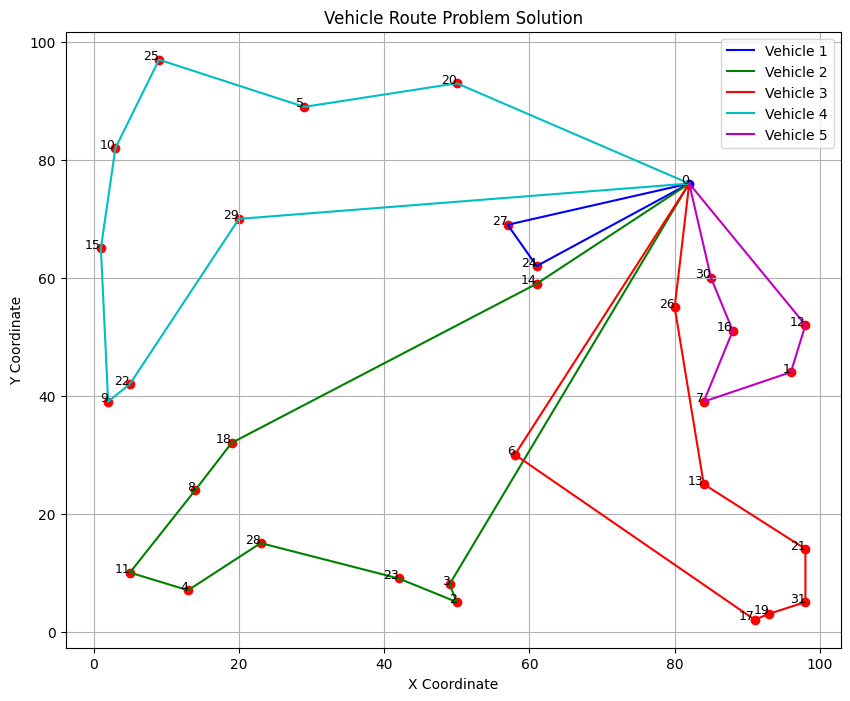

In [ ]:
from matplotlib import pyplot as plt



def print_solution(data, manager, routing, solution):
    if solution:
        total_distance = 0
        routes = []
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            route = []
            route_distance = 0
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                    previous_index, index, vehicle_id)
            total_distance += route_distance
            print(total_distance)
            routes.append(route)
        print(f'Total distance of all routes: {total_distance}m')
        return routes
    else:
        print('No solution found.')
        return []

        
routes = print_solution(data, manager, routing, solution)

def plot_CVRP_solution(routes, node_coords):

    plt.figure(figsize= (10,8))

    # plot nodes
    for i, (x,y) in enumerate(node_coords):
        plt.scatter(x,y, c = 'blue' if i ==0 else 'red')
        plt.text(x,y, f'{i}', fontsize = 9, ha='right')

    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for vehicle, route in enumerate(routes):
        route_coords = [node_coords[0]] + [node_coords[node] for node in route] + [node_coords[0]]
        x_coords, y_coords = zip(*route_coords)
        plt.plot(x_coords, y_coords, c= colors[vehicle % len(colors)], label=f'Vehicle {vehicle +1}')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Route Problem Solution')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_CVRP_solution(routes, data['locations'])

